In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from pandas import Series
%matplotlib inline

# 定义文件全局变量
path = "/Users/skyamz/Desktop/JDD_Loan_Forecasting_Qualification/initdata/"
generate_path = "/Users/skyamz/Desktop/JDD_Loan_Forecasting_Qualification/generate_data/"


# 加载文件
file_order = pd.read_csv(path + "t_order.csv")
file_click = pd.read_csv(path + "t_click.csv")
file_user = pd.read_csv(path + "t_user.csv")
file_loan = pd.read_csv(path + "t_loan.csv")
file_loan_sum = pd.read_csv(path + "t_loan_sum.csv")

# 格式化时间
file_order['buy_time_format'] = pd.to_datetime(file_order['buy_time'])
file_loan['loan_time_format'] = pd.to_datetime(file_loan['loan_time'])

# 创建索引
file_order = file_order.set_index('buy_time_format')
file_loan = file_loan.set_index('loan_time_format')

#聚合用户订单月份数据
def user_order_month_aggregate(month):
    # 取月份数据
    file_order_month = file_order[month]
    # 重置索引
    file_order_month = file_order_month.reset_index()
    # 统计用户订单某个类目的价格、数量、折扣
    file_order_month_sum = file_order_month.groupby(['uid','cate_id'])['price','qty','discount'].sum()
    # 重置索引
    file_order_month_sum = file_order_month_sum.reset_index()
    # 合并2列
    file_order_month_sum['cate_id_and_count'] = file_order_month_sum['cate_id'].astype('str') + ':' +  file_order_month_sum['qty'].astype('str')
    # 统计用户下单类目
    file_order_month_sum_unique_cate_list = file_order_month_sum.groupby('uid')['cate_id_and_count'].unique()
    # 重置索引
    file_order_month_sum_unique_cate_list = file_order_month_sum_unique_cate_list.reset_index()
    # 统计用户订单全部价格、数量、折扣
    file_order_month_total = file_order_month.groupby(['uid'])['price','qty','discount'].sum()
    # 重置索引
    file_order_month_total = file_order_month_total.reset_index()
    # 将数据进行聚合操作
    user_order_month_aggregate = pd.merge(file_order_month_sum_unique_cate_list,file_order_month_total,how='outer',on='uid')
    return user_order_month_aggregate

# 索引各个月份数据
file_order_month_aggregate_11 = user_order_month_aggregate('2016-11')
file_order_month_aggregate_10 = user_order_month_aggregate('2016-10')
file_order_month_aggregate_09 = user_order_month_aggregate('2016-09')
file_order_month_aggregate_08 = user_order_month_aggregate('2016-08')

# 合并
file_click['pid_param'] = file_click['pid'].astype('str') +'_' + file_click['param'].astype('str')

# 用户点击统计
user_click_count = pd.DataFrame(file_click.groupby(['uid','pid_param'])['uid'].count())

# 重命名统计列
user_click_count.columns = ['click_count']

# 查询某个用户的点击统计
def user_click_count_serch(uid):
   user_click_count_serch = user_click_count.xs(uid, level='uid')
   return user_click_count_serch

# 查询某个参数的用户点击
def pid_and_param_click_count_serch(pid_param):
   pid_and_param_click_count_serch = user_click_count.xs(pid_param, level='pid_param')
   return pid_and_param_click_count_serch

# 查询用户的点击统计
# user_click_count_serch(1)

# 查询某个参数的用户点击
# pid_and_param_click_count_serch('8_1')

# 重置索引,并设置索引为uid
user_click_count_detail = user_click_count.reset_index().set_index('uid')

# 统计用户的总点击次数
user_click_count_total = pd.DataFrame(user_click_count.groupby('uid')['click_count'].sum())

# 重命名列名称
user_click_count_total.columns = ['click_count_total']

# 重置索引
user_click_count_total = user_click_count_total.reset_index()

# 合并2列为字典
user_click_count_detail['param_and_click'] = user_click_count_detail['pid_param'].astype('str') + ':' + user_click_count_detail['click_count'].astype('str')

# 合并分组
user_click_count_detail_aggregate = pd.DataFrame(user_click_count_detail.groupby('uid')['param_and_click'].unique())

# 重置索引
user_click_count_detail_aggregate = user_click_count_detail_aggregate.reset_index()

# 用户点击聚合
user_click_count_aggregate = pd.merge(user_click_count_detail_aggregate,user_click_count_total,how='outer',on='uid')

# 各月用户点击和订单数据汇总
user_click_count_and_order_month_aggregate_08 = pd.merge(user_click_count_detail_aggregate,file_order_month_aggregate_08,how='outer',on='uid')
user_click_count_and_order_month_aggregate_09 = pd.merge(user_click_count_detail_aggregate,file_order_month_aggregate_09,how='outer',on='uid')
user_click_count_and_order_month_aggregate_10 = pd.merge(user_click_count_detail_aggregate,file_order_month_aggregate_10,how='outer',on='uid')
user_click_count_and_order_month_aggregate_11 = pd.merge(user_click_count_detail_aggregate,file_order_month_aggregate_11,how='outer',on='uid')

# 重置索引
user_click_count_detail = user_click_count_detail.reset_index()

# 统计用户最大点击
user_click_count_detail_max = user_click_count_detail.loc[user_click_count_detail.groupby(['uid'])['click_count'].idxmax()].sort_values(by='uid')

# 查询每月订单最大数量
def file_order_month_max(month):
    file_order_month_sum = file_order[month].reset_index().groupby(['uid','cate_id'])['price','qty','discount'].sum().reset_index()
    file_order_month_sum.loc[file_order_month_sum.groupby(['uid'])['qty'].idxmax()].sort_values(by='uid')
    file_order_month_sum_max = file_order_month_sum.loc[file_order_month_sum.groupby(['uid'])['qty'].idxmax()].sort_values(by='uid')
    file_order_month_sum_max.columns = ['uid','cate_id_by_max_qty','price_by_max_qty','qty_max','discount_by_max_qty']
    return file_order_month_sum_max

# 查询点击最多次数和购买数量最大
def click_count_max_and_order_qty_max(month):
    click_count_max_and_order_qty_max = pd.merge(user_click_count_detail_max,file_order_month_max(month),how='outer',on='uid')
    click_count_max_and_order_qty_max = pd.merge(click_count_max_and_order_qty_max,file_user,how='outer',on='uid')
    return click_count_max_and_order_qty_max

# 统计贷款笔数
def loan_count(month):
    file_loan_count = pd.DataFrame(file_loan[month].groupby('uid')['uid'].count())
    file_loan_count.columns = ['loan_count']
    file_loan_count = file_loan_count.reset_index()
    file_loan_sum = pd.DataFrame(file_loan[month].groupby(['uid'])['loan_amount'].sum())
    file_loan_sum.columns = ['loan_sum']
    file_loan_sum = file_loan_sum.reset_index()
    file_loan_count_and_sum = pd.merge(file_loan_count,file_loan_sum,how='outer',on='uid')
    file_loan_count_and_sum['loan_sum_mean'] = file_loan_count_and_sum['loan_sum']/file_loan_count_and_sum['loan_count']
    return file_loan_count_and_sum

#打标用户当月是否借贷
def is_month_loan_user(month):
    loan_month = file_loan[month]
    is_loan_user = loan_month['uid'].unique()
    is_loan_user = pd.DataFrame(Series(is_loan_user))
    is_loan_user.columns = ['uid']
    is_loan_user['is_loan'] = 1
    return is_loan_user

#构建每个月的用户特征
def feature_month_uid(month,prefix_name):
    click_count_max_and_order_qty_max_tmp = click_count_max_and_order_qty_max(month)
    loan_count_tmp = loan_count(month)
    feature_month_uid = pd.merge(click_count_max_and_order_qty_max_tmp,loan_count_tmp,how='outer',on='uid')
    is_month_loan_user_tmp = is_month_loan_user(month)
    feature_month_uid = pd.merge(feature_month_uid,is_month_loan_user_tmp,how='outer',on='uid')
    feature_month_uid['diff'] = feature_month_uid['limit'] - feature_month_uid['loan_sum_mean']
    #one_hot_pid_param = pd.get_dummies(feature_month_uid['pid_param'])
    #one_hot_cate_id_by_max_qty = pd.get_dummies(feature_month_uid['cate_id_by_max_qty'])
    #one_hot_pid_param['uid'] = feature_month_uid['uid']
    #one_hot_cate_id_by_max_qty['uid'] = feature_month_uid['uid']
    #one_hot_all = pd.merge(one_hot_pid_param,one_hot_cate_id_by_max_qty,how = 'outer',on='uid')
    #feature_month_uid = pd.merge(feature_month_uid,one_hot_all,how='outer',on='uid')
    
    del feature_month_uid['param_and_click']
    #del feature_month_uid['pid_param']
    #del feature_month_uid['cate_id_by_max_qty']
    feature_month_uid['loan_sum'] = feature_month_uid['loan_sum']/10
    feature_month_uid['limit'] = feature_month_uid['limit']/10
    feature_month_uid['loan_sum_mean'] = feature_month_uid['loan_sum_mean']/10
    feature_month_uid.columns = [col+prefix_name for col in feature_month_uid.columns.values.astype('str')]
    feature_month_uid = feature_month_uid.rename(columns={"uid"+prefix_name:"uid"})
    feature_month_uid = feature_month_uid.where(feature_month_uid.notnull(), 0)

    return feature_month_uid

# 取各月数据
feature_month_uid_8 = feature_month_uid('2016-08','_8')
feature_month_uid_9 = feature_month_uid('2016-09','_9')
feature_month_uid_10 = feature_month_uid('2016-10','_10')
feature_month_uid_11 = feature_month_uid('2016-11','_11')

# 合并每个月数据
feature_month_uid_8_9 = pd.merge(feature_month_uid_8,feature_month_uid_9,how='outer',on='uid')
feature_month_uid_10_11 = pd.merge(feature_month_uid_10,feature_month_uid_11,how='outer',on='uid')
feature_month_uid_all = pd.merge(feature_month_uid_8_9,feature_month_uid_10_11,how='outer',on='uid')

# 替换所有nan为0
feature_month_uid_all_replace_none = feature_month_uid_all.where(feature_month_uid_all.notnull(), 0)

# 按uid从小到大排序
feature_month_uid_all_replace_none = feature_month_uid_all_replace_none.sort_values(by='uid')

def build_train_set():
    loan_and_user = pd.merge(file_loan_sum,file_user,how='outer',on='uid')
    loan_and_user = loan_and_user.sort_values(by='uid')
    loan_and_user['loan_sum'] = loan_and_user['loan_sum']/10
    del loan_and_user['age']
    del loan_and_user['sex']
    del loan_and_user['active_date']
    del loan_and_user['limit']
    # 取前80%作为训练集
    feature_month_uid_all_replace_none_NAN_no_one_hot = pd.merge(feature_month_uid_all_replace_none , loan_and_user,how='outer',on='uid')
    feature_month_uid_all_replace_none_NAN_no_one_hot = feature_month_uid_all_replace_none_NAN_no_one_hot.where(feature_month_uid_all_replace_none_NAN_no_one_hot.notnull(), 0)
    feature_month_uid_all_replace_none_NAN_no_one_hot = feature_month_uid_all_replace_none_NAN_no_one_hot[(feature_month_uid_all_replace_none_NAN_no_one_hot['is_loan_11']==1.0) | (feature_month_uid_all_replace_none_NAN_no_one_hot['is_loan_10']==1.0)|(feature_month_uid_all_replace_none_NAN_no_one_hot['is_loan_9']==1.0)|(feature_month_uid_all_replace_none_NAN_no_one_hot['is_loan_8']==1.0)]
    
    train_feature_month_uid_all_replace_none = feature_month_uid_all_replace_none_NAN_no_one_hot[:int(len(feature_month_uid_all_replace_none_NAN_no_one_hot['uid'])*0.8)]
    return train_feature_month_uid_all_replace_none

def build_test_set():
    loan_and_user = pd.merge(file_loan_sum,file_user,how='outer',on='uid')
    loan_and_user = loan_and_user.sort_values(by='uid')
    loan_and_user['loan_sum'] = loan_and_user['loan_sum']/10
    del loan_and_user['age']
    del loan_and_user['sex']
    del loan_and_user['active_date']
    del loan_and_user['limit']
    # 取前80%作为训练集
    feature_month_uid_all_replace_none_NAN_no_one_hot = pd.merge(feature_month_uid_all_replace_none , loan_and_user,how='outer',on='uid')
    feature_month_uid_all_replace_none_NAN_no_one_hot = feature_month_uid_all_replace_none_NAN_no_one_hot.where(feature_month_uid_all_replace_none_NAN_no_one_hot.notnull(), 0)
    feature_month_uid_all_replace_none_NAN_no_one_hot = feature_month_uid_all_replace_none_NAN_no_one_hot[(feature_month_uid_all_replace_none_NAN_no_one_hot['is_loan_11']==1.0) | (feature_month_uid_all_replace_none_NAN_no_one_hot['is_loan_10']==1.0)|(feature_month_uid_all_replace_none_NAN_no_one_hot['is_loan_9']==1.0)|(feature_month_uid_all_replace_none_NAN_no_one_hot['is_loan_8']==1.0)]
    
    test_feature_month_uid_all_replace_none = feature_month_uid_all_replace_none_NAN_no_one_hot[int(len(feature_month_uid_all_replace_none_NAN_no_one_hot['uid'])*0.8)+1:]
    del test_feature_month_uid_all_replace_none['loan_sum']
    # 替换所有nan为0
    build_test_set = test_feature_month_uid_all_replace_none.where(test_feature_month_uid_all_replace_none.notnull(), 0)
    return build_test_set

build_train_set = build_train_set()

build_test_set = build_test_set()

build_train_set.to_csv(generate_path + 'build_train_set.csv')

build_test_set.to_csv(generate_path + 'build_test_set.csv')


In [22]:
dtrain = xgb.DMatrix(generate_path + 'build_train_set.libsvm')

dtest = xgb.DMatrix(generate_path + 'build_test_set.libsvm')

XGBoostError: b'[11:23:25] src/data/./row_block.h:170: Check failed: offset.back() == value.size() || value.size() == 0 \n\nStack trace returned 2 entries:\n[bt] (0) 0   libxgboost.dylib                    0x0000000109dd07d9 _ZN4dmlc15LogMessageFatalD1Ev + 41\n[bt] (1) 1   libstdc++.6.dylib                   0x000000010a18ef80 _ZTVNSt7__cxx1115basic_stringbufIcSt11char_traitsIcESaIcEEE + 16\n'

In [23]:
build_train_set

,uid,pid_param_8,click_count_8,cate_id_by_max_qty_8,price_by_max_qty_8,qty_max_8,discount_by_max_qty_8,age_8,sex_8,active_date_8,...,age_11,sex_11,active_date_11,limit_11,loan_count_11,loan_sum_11,loan_sum_mean_11,is_loan_11,diff_11,loan_sum
3,4,10_16,50.0,22.0,14.665733,4.0,11.159862,30,1,2016-03-26,...,30,1,2016-03-26,0.529215,1.0,0.472302,0.472302,1.0,0.569137,0.472302
4,5,8_1,7.0,1.0,52.248393,36.0,24.480130,30,2,2015-12-08,...,30,2,2015-12-08,0.629205,1.0,0.658407,0.658407,1.0,-0.292020,0.658407
5,6,10_28,112.0,36.0,11.949272,4.0,2.554230,25,1,2016-04-13,...,25,1,2016-04-13,0.629205,1.0,0.626669,0.626669,1.0,0.025363,0.626669
16,17,10_16,18.0,44.0,2.647676,4.0,3.074837,30,2,2016-05-31,...,30,2,2016-05-31,0.529215,1.0,0.565731,0.565731,1.0,-0.365157,0.565731
18,19,7_9,3.0,0.0,0.000000,0.0,0.000000,50,1,2016-03-04,...,50,1,2016-03-04,0.597468,1.0,0.588577,0.588577,1.0,0.088907,0.588577
19,20,10_16,29.0,3.0,18.710273,8.0,16.992488,35,1,2016-01-28,...,35,1,2016-01-28,0.629205,0.0,0.000000,0.000000,0.0,0.000000,0.000000
22,23,10_16,79.0,10.0,25.752178,9.0,15.675134,35,1,2015-12-17,...,35,1,2015-12-17,0.572277,1.0,0.386259,0.386259,1.0,1.860174,0.386259
25,26,8_1,120.0,36.0,11.732608,4.0,3.381564,35,1,2016-06-18,...,35,1,2016-06-18,0.629205,0.0,0.000000,0.000000,0.0,0.000000,0.000000
26,27,10_28,7.0,25.0,27.240113,10.0,13.536703,30,1,2016-02-07,...,30,1,2016-02-07,0.572277,0.0,0.000000,0.000000,0.0,0.000000,0.000000
27,28,10_28,33.0,10.0,9.793121,3.0,6.589657,25,1,2016-04-05,...,25,1,2016-04-05,0.615341,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [3]:
param = {'max_depth':4, 'eta':0.3, 'silent':1, 'objective':'binary:logistic' }
num_round = 5
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)
labels = dtest.get_label()

In [4]:
for i in labels:
    print (i)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [19]:
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth = param)
    test_score = np.sqrt(-cross_val_score(clf, train_df, Log_train_Y, cv=50, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

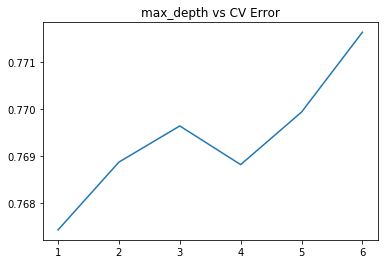

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error");

In [178]:
dtrain = xgb.DMatrix('t_loan_sum.libsvm')

In [47]:
feature_month_uid_all_replace_none

,uid,pid_param_8,click_count_8,param_and_click_8,cate_id_by_max_qty_8,price_by_max_qty_8,qty_max_8,discount_by_max_qty_8,age_8,sex_8,...,discount_by_max_qty_11,age_11,sex_11,active_date_11,limit_11,loan_count_11,loan_sum_11,loan_sum_mean_11,is_loan_11,diff_11
0,1,8_1,66.0,8_1:66,22.0,73.158573,22.0,18.936605,35,1,...,6.536894,35,1,2016-04-27,5.974677,0.0,0.000000,0.000000,0.0,0.000000
78439,2,0,0.0,0,3.0,9.472811,6.0,4.491791,40,1,...,4.623552,40,1,2016-03-30,6.153414,0.0,0.000000,0.000000,0.0,0.000000
78440,3,0,0.0,0,44.0,31.280407,8.0,13.820537,30,2,...,3.437597,30,2,2016-05-08,6.292055,0.0,0.000000,0.000000,0.0,0.000000
1,4,10_16,50.0,10_16:50,22.0,14.665733,4.0,11.159862,30,1,...,0.000000,30,1,2016-03-26,5.292154,1.0,4.723017,4.723017,1.0,0.569137
2,5,8_1,7.0,8_1:7,1.0,52.248393,36.0,24.480130,30,2,...,21.030112,30,2,2015-12-08,6.292055,1.0,6.584075,6.584075,1.0,-0.292020
3,6,10_28,112.0,10_28:112,36.0,11.949272,4.0,2.554230,25,1,...,13.759507,25,1,2016-04-13,6.292055,1.0,6.266691,6.266691,1.0,0.025363
4,7,10_16,33.0,10_16:33,0.0,0.000000,0.0,0.000000,30,1,...,0.000000,30,1,2016-02-06,6.153414,0.0,0.000000,0.000000,0.0,0.000000
5,8,10_16,81.0,10_16:81,1.0,43.810418,42.0,8.127342,35,1,...,0.000000,35,1,2016-04-15,6.153414,0.0,0.000000,0.000000,0.0,0.000000
6,9,10_28,5.0,10_28:5,26.0,11.585922,3.0,0.000000,40,1,...,2.419391,40,1,2015-12-27,6.292055,0.0,0.000000,0.000000,0.0,0.000000
78441,10,0,0.0,0,10.0,29.252775,9.0,9.680118,30,1,...,4.446189,30,1,2016-02-13,5.292154,0.0,0.000000,0.000000,0.0,0.000000


XGBoostError: b'[16:14:56] src/data/./row_block.h:170: Check failed: offset.back() == value.size() || value.size() == 0 \n\nStack trace returned 2 entries:\n[bt] (0) 0   libxgboost.dylib                    0x000000012eadf7d9 _ZN4dmlc15LogMessageFatalD1Ev + 41\n[bt] (1) 1   libstdc++.6.dylib                   0x00000001348dbf80 _ZTVNSt7__cxx1115basic_stringbufIcSt11char_traitsIcESaIcEEE + 16\n'

In [41]:
loan_and_user = pd.merge(file_loan_sum,file_user,how='outer',on='uid')
loan_and_user = loan_and_user.sort_values(by='uid')
del loan_and_user['age']
del loan_and_user['sex']
del loan_and_user['active_date']
del loan_and_user['limit']
    # 取前80%作为训练集
train_Label = loan_and_user[:int(len(loan_and_user['uid'])*0.8)]
train_Label = train_Label.where(train_Label.notnull(), 0)

train_Label

,uid,loan_sum
65591,1,0.000000
62373,2,0.000000
56003,3,0.000000
4862,4,4.723017
1123,5,6.584075
5438,6,6.266691
63568,7,0.000000
30004,8,0.000000
32838,9,0.000000
50504,10,0.000000


In [42]:
feature_month_uid_all_replace_none.to_csv(path + 'feature_month_uid_all_replace_none.csv')

In [46]:
xgb.DMatrix(path+'feature_month_uid_all_replace_none.libsvm')

XGBoostError: b'[16:06:20] src/data/./row_block.h:170: Check failed: offset.back() == value.size() || value.size() == 0 \n\nStack trace returned 2 entries:\n[bt] (0) 0   libxgboost.dylib                    0x000000012eadf7d9 _ZN4dmlc15LogMessageFatalD1Ev + 41\n[bt] (1) 1   libstdc++.6.dylib                   0x00000001348dbf80 _ZTVNSt7__cxx1115basic_stringbufIcSt11char_traitsIcESaIcEEE + 16\n'

In [44]:
#train_feature_month_uid_all_replace_none = feature_month_uid_all_replace_none[:int(len(feature_month_uid_all_replace_none['uid'])*0.8)]

train_feature_month_uid_all_replace_none = train_feature_month_uid_all_replace_none.where(train_feature_month_uid_all_replace_none.notnull(), 0)

train_feature_month_uid_all_replace_none

,uid,pid_param_8,click_count_8,param_and_click_8,cate_id_by_max_qty_8,price_by_max_qty_8,qty_max_8,discount_by_max_qty_8,age_8,sex_8,...,discount_by_max_qty_11,age_11,sex_11,active_date_11,limit_11,loan_count_11,loan_sum_11,loan_sum_mean_11,is_loan_11,diff_11
0,1,8_1,66.0,8_1:66,22.0,73.158573,22.0,18.936605,35,1,...,6.536894,35,1,2016-04-27,5.974677,0.0,0.000000,0.000000,0.0,0.000000
78439,2,0,0.0,0,3.0,9.472811,6.0,4.491791,40,1,...,4.623552,40,1,2016-03-30,6.153414,0.0,0.000000,0.000000,0.0,0.000000
78440,3,0,0.0,0,44.0,31.280407,8.0,13.820537,30,2,...,3.437597,30,2,2016-05-08,6.292055,0.0,0.000000,0.000000,0.0,0.000000
1,4,10_16,50.0,10_16:50,22.0,14.665733,4.0,11.159862,30,1,...,0.000000,30,1,2016-03-26,5.292154,1.0,4.723017,4.723017,1.0,0.569137
2,5,8_1,7.0,8_1:7,1.0,52.248393,36.0,24.480130,30,2,...,21.030112,30,2,2015-12-08,6.292055,1.0,6.584075,6.584075,1.0,-0.292020
3,6,10_28,112.0,10_28:112,36.0,11.949272,4.0,2.554230,25,1,...,13.759507,25,1,2016-04-13,6.292055,1.0,6.266691,6.266691,1.0,0.025363
4,7,10_16,33.0,10_16:33,0.0,0.000000,0.0,0.000000,30,1,...,0.000000,30,1,2016-02-06,6.153414,0.0,0.000000,0.000000,0.0,0.000000
5,8,10_16,81.0,10_16:81,1.0,43.810418,42.0,8.127342,35,1,...,0.000000,35,1,2016-04-15,6.153414,0.0,0.000000,0.000000,0.0,0.000000
6,9,10_28,5.0,10_28:5,26.0,11.585922,3.0,0.000000,40,1,...,2.419391,40,1,2015-12-27,6.292055,0.0,0.000000,0.000000,0.0,0.000000
78441,10,0,0.0,0,10.0,29.252775,9.0,9.680118,30,1,...,4.446189,30,1,2016-02-13,5.292154,0.0,0.000000,0.000000,0.0,0.000000


In [45]:
feature_month_uid_all_replace_none.to_csv(path + 'feature_month_uid_all_replace_none.csv')

In [ ]:
feature_month_uid_all_replace_none_NAN_no_one_hot = pd.merge(train_feature_month_uid_all_replace_none , train_Label,how='outer',on='uid')
    # 替换所有nan为0
feature_month_uid_all_replace_none_NAN_no_one_hot = feature_month_uid_all_replace_none_NAN_no_one_hot.where(feature_month_uid_all_replace_none_NAN_no_one_hot.notnull(), 0)


In [41]:
array= [1,2,3,4,5,6,7]
tmp=[]
for i in range(0,len(array)-1,2):
    tmp.append(str(array[i])+str(array[i+1]))
if len(array)%2!=0:
    tmp.append(str(array[-1]))
print(tmp)

['12', '34', '56', '7']


In [42]:
tmp

['12', '34', '56', '7']

In [45]:
array = tmp
tmp = []
for i in range(0,len(array)-1,2):
    tmp.append(str(array[i])+str(array[i+1]))
if len(array)%2!=0:
    tmp.append(str(array[-1]))
print(tmp)

['1234567']


In [109]:
def multi_merge(array):
    if len(array)==1:
        print(array)
        return array[0]
    else:
        tmp = []
        for i in range(0,len(array)-1,2):
            tmp.append(str(array[i])+str(array[i+1]))
        if len(array)%2!=0:
            tmp.append(str(array[-1]))
        multi_merge(tmp)

In [110]:
array = [1,2,3,4,5]

In [111]:
multi_merge(array)

['12345']


In [102]:
test = ['12345']
test[0]

'12345'

In [209]:
def multi_merge(array):
    if len(array)==1:
        return array
    else:
        tmp = []
        for i in range(0,len(array)-1,2):
            merge = pd.merge(array[i],array[i+1],how='outer',on='uid')
            merge = merge.reset_index()
            tmp.append(merge)
            print('0')
            print(type(tmp[0]))
        if len(array)%2!=0:
            tmp.append(array[-1])
            print('1')
            print(type(tmp[1]))
        return multi_merge(tmp)

In [176]:
def multi_merge(array):
    if len(array)==1:
        return array
    else:
        tmp = []
        for i in range(0,len(array)-1,2):
            merge = pd.merge(array[i],array[i+1],how='outer',on='uid')
            merge = merge.reset_index()
            tmp.append(merge)
            print(type(merge))
        #if len(array)%2!=0:
           # tmp.append(array[-1])
        return multi_merge(tmp)

In [206]:
array = [feature_month_uid_8,feature_month_uid_9,feature_month_uid_10]

In [210]:
a = multi_merge(array)

0
<class 'pandas.core.frame.DataFrame'>
1
<class 'pandas.core.frame.DataFrame'>
0
<class 'pandas.core.frame.DataFrame'>


In [204]:
a

[       level_0  index    uid pid_param_8  click_count_8  cate_id_by_max_qty_8  \
 0            0      0      1         8_1           66.0                  22.0   
 1            1      1      4       10_16           50.0                  22.0   
 2            2      2      5         8_1            7.0                   1.0   
 3            3      3      6       10_28          112.0                  36.0   
 4            4      4      7       10_16           33.0                   0.0   
 5            5      5      8       10_16           81.0                   1.0   
 6            6      6      9       10_28            5.0                  26.0   
 7            7      7     11         8_1            7.0                   9.0   
 8            8      8     14       10_16           67.0                  26.0   
 9            9      9     16         6_5           14.0                  14.0   
 10          10     10     17       10_16           18.0                  44.0   
 11          11 